## Time Series Forecasting in R

Since it was a little clumsy to perform time series forecasting in python, I decided to try the R forecasting package in R (via the R kernel in Jupyter notebooks).

I saved my time glucose time grid data as a csv, so to begin I will import it into an R dataframe.

In [22]:
library(forecast)

In [2]:
#Load file (not a csv technically)
glucTimeTable <- read.table('diabetes_analysis_glucTimeGrid', 
                            header=TRUE, sep= ',')

In [3]:
#Get data type
typeof(glucTimeTable)

[1] "list"

In [4]:
#Turn list into a dataframe and get the first couple of rows
data= data.frame(glucTimeTable)
head(data)

X,X1,X2,X3,X4,X5,X6,X7,X8,X9,⋯,X61,X62,X63,X64,X65,X67,X68,X69,X70,dates
0,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,158.0,NA,NA,1988-03-27
1,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,135.0,NA,NA,1988-03-28
2,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,147.0,NA,NA,1988-03-31
3,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,136.0,NA,NA,1988-04-02
4,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,111.5,NA,NA,1988-04-04
5,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,140.0,NA,NA,1988-04-06


In [5]:
#Remove first column from dataframe
x1= data$X1

In [6]:
#Remove the nans 
x1= x1[!is.na(x1)]


In [7]:
#Let's check the length of our non-nan list
print(length(x1))

#Calc 80% boundary
trainBound= round(length(x1)*0.8)
print(trainBound)

[1] 136
[1] 109


In [8]:
#Split into training and testing sets
train= x1[1:trainBound]
test= tail(x1, -trainBound)

print(length(train))
print(length(test))

[1] 109
[1] 27


Let's first adjust the size of our figures (default is currently very large 7x7 inch figures).

In [9]:
options(repr.plot.width=7, repr.plot.height=3)

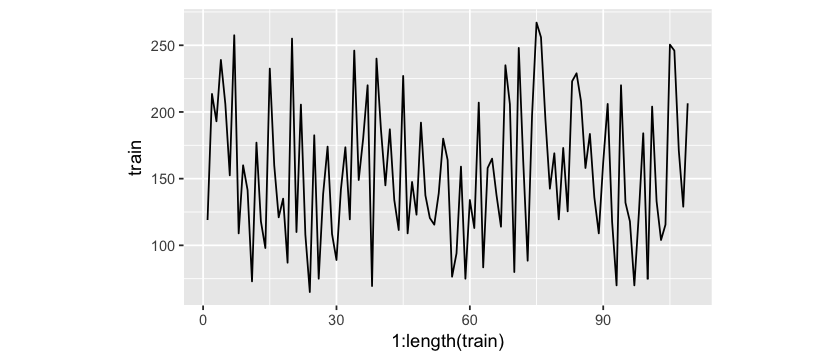

In [10]:
#Load ggplot and plot a line of our first column (subject 1)
library(ggplot2)
linePlot= qplot(1:length(train),train, geom= 'line')
linePlot + coord_fixed(ratio= 0.3)

### STL Decomposition

Here I will quickly remake the plots I made in the python notebook. First I'll remake the season trend, irregular/remainder plot.

In [11]:
#Convert vector to a time series object
tsTrain= ts(train, frequency= 7)

In [12]:
#Define parameters for season (s) and trend (t) for a fit
fit= stl(tsTrain, s.window= 'periodic', robust=TRUE)

#Get a summary of fit object components
summary(fit)

 Call:
 stl(x = tsTrain, s.window = "periodic", robust = TRUE)

 Time.series components:
    seasonal              trend            remainder         
 Min.   :-19.681130   Min.   :121.0115   Min.   :-102.73529  
 1st Qu.:-10.932138   1st Qu.:137.8649   1st Qu.: -36.40677  
 Median :  1.553944   Median :147.8688   Median :  -1.33483  
 Mean   : -0.197363   Mean   :154.7800   Mean   :   0.72008  
 3rd Qu.:  8.894581   3rd Qu.:174.1799   3rd Qu.:  34.13303  
 Max.   : 17.615660   Max.   :200.9293   Max.   : 109.18581  
 IQR:
     STL.seasonal STL.trend STL.remainder data 
     19.83        36.32     70.54         78.50
   %  25.3         46.3      89.9         100.0

 Weights:
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.5627398 0.8840063 0.9452160 0.9166585 0.9896134 1.0000000 

 Other components: List of 5
 $ win  : Named num [1:3] 1091 11 7
 $ deg  : Named int [1:3] 0 1 1
 $ jump : Named num [1:3] 110 2 1
 $ inner: int 1
 $ outer: int 15


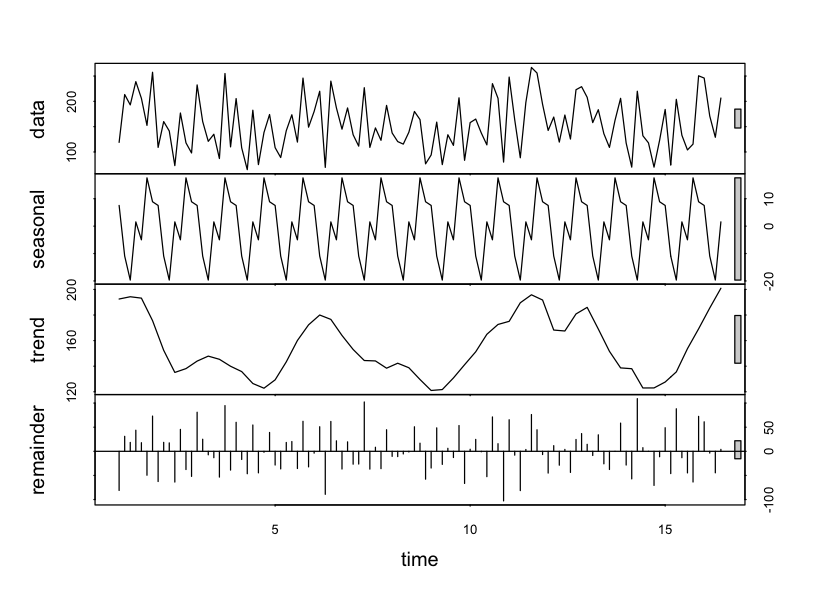

In [13]:
options(repr.plot.width=7, repr.plot.height=5)

#Decomposed time series
plot(fit)

The plots above show that there's not a strong seasonal component or a trend, so it may be a good assumption to make that it's stationary (constant mean and variance). We can now use an autoregressive (AR) and moving average (MA) model to forecast future results.

## Forecasting with ARIMA Models

### Autocorrelation Coefficients

We'll need to do some final characterization of our time series data to determine which type of arima model we'll use. One of the assumptions needed before moving forward is that our data complies with the <strong>White Noise Model</strong>. In essence, that our noise is random and that the error for each observation is not correlated to the error from other observations.

Plotting the <strong>autocorrelation function</strong> should allow us to see if any of the autocorrelation coefficients of our data (one for each lag) is significantly larger than zero.

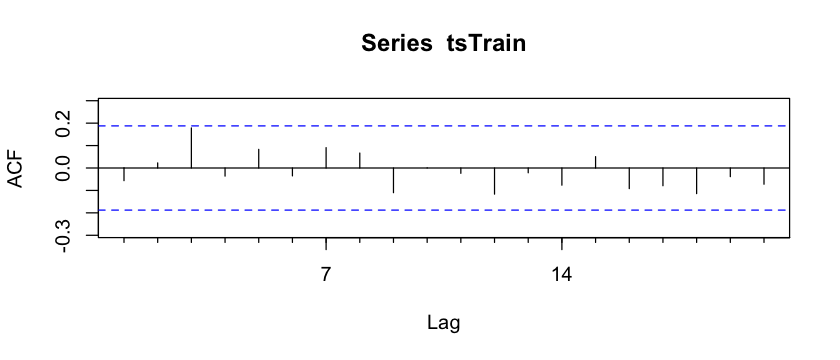

In [14]:
options(repr.plot.width=7, repr.plot.height=3)

#Autocorrelation function of our time series
#the dashed lines are the 1.96/squared(n) critical values 
Acf(tsTrain)

The autocorrelation coefficients are below our critical values in the ACF plot, indicating that our time series obeys the White Noise Model. We can verify the results of this using the Box-Pierce test and compare our significance value to a threshold to a value of say, p = 0.05 .

In [15]:
#The Box test is a hypothesis test to see 
#if any of the time series autocorrelation coefficients are 
#large enough to be a feature of our data and not random

Box.test(tsTrain)


	Box-Pierce test

data:  tsTrain
X-squared = 0.34708, df = 1, p-value = 0.5558


Since our p-value is greater than 0.05, we can say that our autocorrelation coefficients do follow the White Noise Model.

### Partial Correlation Coefficients

By calculating the partial correlation coefficients, we can fdetermine what the correlation of a time point is with another time point when the effect of other time lags are removed. Like with the ACF, if our time series follows a White Noise Model then we expect that the coefficients will be normally distributed around zero (and we'll use the same critical values as thresholds like before).

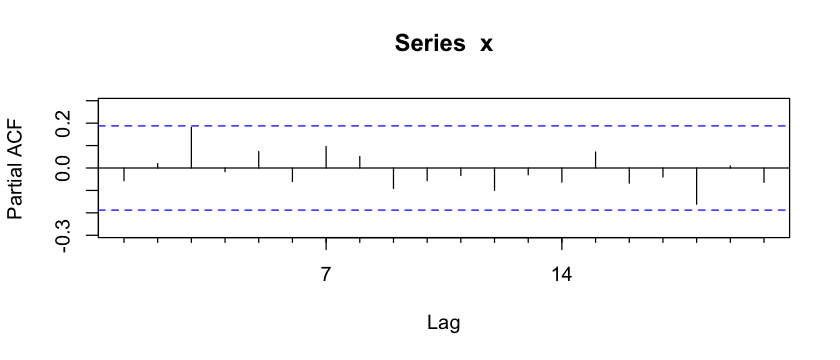

In [24]:
Pacf(tsTrain)

Great! Now that we've verified that our time series is following the White Noise Model, we can be confident that ARIMA methods will be applicable to our dataset.

In [16]:
fitArima <- Arima(tsTrain, order=c(1,0,1))
summary(fitArima)

Series: tsTrain 
ARIMA(1,0,1) with non-zero mean 

Coefficients:
          ar1     ma1  intercept
      -0.0923  0.0355   155.2959
s.e.   0.6233  0.6156     4.7734

sigma^2 estimated as 2839:  log likelihood=-586.49
AIC=1180.97   AICc=1181.36   BIC=1191.74

Training set error measures:
                      ME     RMSE      MAE       MPE     MAPE      MASE
Training set -0.01850752 52.54413 44.34431 -13.65371 33.82796 0.7953438
                     ACF1
Training set 0.0006275245


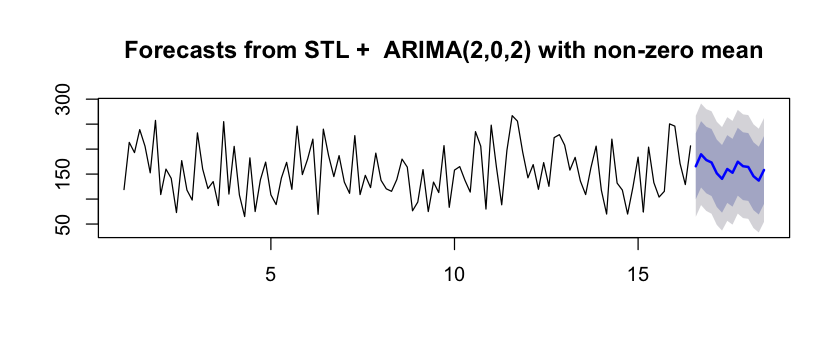

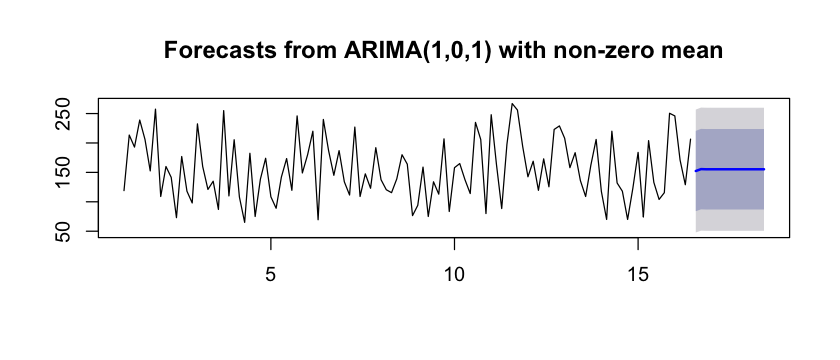

In [17]:
fcastArima= forecast(fit, method= 'arima')
forecastArima= forecast(fitArima)

plot(fcastArima)
plot(forecastArima)

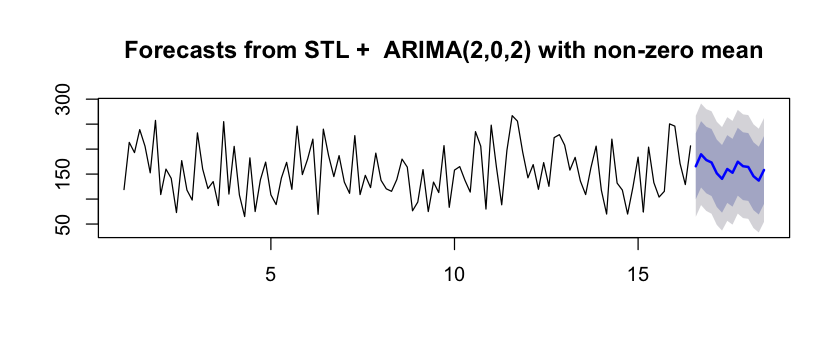

In [18]:
fcastNaive= forecast(fit, method= 'naive')
fcastETS= forecast(fit, method= 'ets')
fcastArima= forecast(fit, method= 'arima')
fcastRWDRIFT= forecast(fit, method= 'rwdrift')

# plot(fcastNaive)
# plot(fcastRWDRIFT)
# plot(fcastETS)
plot(fcastArima)

Now let's try overlaying the full time series on top of the forecasts to see how they performed. 

In [19]:
fullTS= ts(x1, frequency= 7)

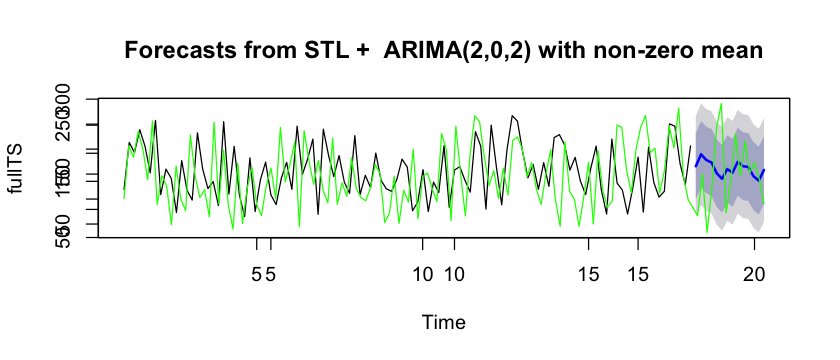

In [20]:
plot(fcastArima)
par(new=TRUE)
plot(fullTS, col= 'green')

In [21]:
max(tsTrain)

[1] 267